<a href="https://colab.research.google.com/github/opinner/Articles/blob/main/Articles/Potential_Density_Shenanigans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Potential Density and Reference pressures

This article can also be viewed and interacted with in Google Colab.

**The text components of this article are not finished yet, but hopefully soon.**

Introduction ??????????????????????????????????????????????????


In [2]:
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
plt.rcParams.update({
    "figure.facecolor":  "white",
    "savefig.facecolor": "white",
    "figure.figsize": [8,6]
})
!pip install gsw
import gsw #Gibbs Seawater Toolbox https://github.com/TEOS-10/GSW-Python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 19.0 MB/s eta 0:00:00


# Download CTD data from Pangaea

This data is from the Polarstern expedition PS107 and can be found here https://doi.pangaea.de/10.1594/PANGAEA.881076.

In [3]:
url= "https://doi.pangaea.de/10.1594/PANGAEA.881076?format=textfile"
data = pd.read_csv(url, delimiter = "\t", skiprows=78)
data

,Event,Date/Time,Latitude,Longitude,Elevation [m],Depth water [m],Press [dbar],Temp [°C],Cond [mS/cm],Sal,Tpot [°C],Sigma-theta [kg/m**3],O2 [µmol/l],O2 sat [%],Attenuation [arbitrary units],Fluorometer [arbitrary units],NOBS [#]
0,PS103_1-1,2016-12-20T13:22,-45.9549,6.2873,NaN,5.0,5,5.2788,32.6967,33.8338,5.2784,26.7185,334.377,105.52,75.54,0.38,8
1,PS103_1-1,2016-12-20T13:22,-45.9549,6.2873,NaN,6.0,6,5.2876,32.7052,33.8342,5.2871,26.7178,334.089,105.45,87.20,0.38,16
2,PS103_1-1,2016-12-20T13:22,-45.9549,6.2873,NaN,6.9,7,5.2860,32.7040,33.8339,5.2855,26.7178,334.242,105.49,88.10,0.39,14
3,PS103_1-1,2016-12-20T13:22,-45.9549,6.2873,NaN,7.9,8,5.2472,32.6700,33.8336,5.2466,26.7221,334.715,105.54,88.07,0.44,12
4,PS103_1-1,2016-12-20T13:22,-45.9549,6.2873,NaN,8.9,9,5.2497,32.6728,33.8338,5.2490,26.7220,334.284,105.41,88.02,0.49,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135593,PS103_73-1,2017-01-30T14:15,-58.4732,-59.6448,-3772.0,302.9,306,1.5835,30.1951,34.5473,1.5679,27.6419,196.284,56.77,91.69,-0.02,18
135594,PS103_73-1,2017-01-30T14:15,-58.4732,-59.6448,-3772.0,303.9,307,1.5920,30.2044,34.5493,1.5763,27.6429,195.932,56.68,91.68,-0.02,14
135595,PS103_73-1,2017-01-30T14:15,-58.4732,-59.6448,-3772.0,304.9,308,1.6089,30.2229,34.5536,1.5931,27.6451,195.908,56.70,91.69,-0.02,18
135596,PS103_73-1,2017-01-30T14:15,-58.4732,-59.6448,-3772.0,305.9,309,1.6477,30.2622,34.5601,1.6318,27.6475,195.515,56.64,91.70,-0.02,21


### Pick a profile

In [20]:
grouped_data = data.groupby("Event")
events = grouped_data.groups.keys()
print(f"Number of Events/Casts = {len(events)}")
profile = grouped_data.get_group("PS103_51-1").reset_index(drop = True)

Number of Events/Casts = 51


### Keep only necessary columns

In [22]:
profile = profile[['Event', 'Latitude', 'Longitude', 'Depth water [m]', 'Press [dbar]', 'Temp [°C]', 'Sal']]
profile

,Event,Latitude,Longitude,Depth water [m],Press [dbar],Temp [°C],Sal
0,PS103_51-1,-63.8924,-49.0801,5.0,5,0.0302,33.5496
1,PS103_51-1,-63.8924,-49.0801,5.9,6,0.0291,33.5496
2,PS103_51-1,-63.8924,-49.0801,6.9,7,0.0269,33.5496
3,PS103_51-1,-63.8924,-49.0801,7.9,8,0.0294,33.5496
4,PS103_51-1,-63.8924,-49.0801,8.9,9,0.0317,33.5495
...,...,...,...,...,...,...,...
3508,PS103_51-1,-63.8924,-49.0801,3450.2,3513,-1.1521,34.6263
3509,PS103_51-1,-63.8924,-49.0801,3451.2,3514,-1.1520,34.6262
3510,PS103_51-1,-63.8924,-49.0801,3452.1,3515,-1.1520,34.6263
3511,PS103_51-1,-63.8924,-49.0801,3453.1,3516,-1.1512,34.6265


### Variable conversions

* _Sal_ is Potential Salinity in the Pseudounit PSU
* _Temp [°C]_ the in-situ temperature in ITS-90

All conversions are done with the python version of the Gibbs Seawater toolbox [GSW-Python](https://github.com/TEOS-10/GSW-Python)

In [23]:
profile["Absolute Salinity"] = gsw.SA_from_SP(
    SP=profile["Sal"], p=profile["Press [dbar]"], lon=profile["Longitude"], lat=profile["Latitude"]
)
profile["Conservative Temperature"] = gsw.CT_from_t(
    SA=profile["Absolute Salinity"], t=profile["Temp [°C]"], p=profile["Press [dbar]"]
)

profile.head()

,Event,Latitude,Longitude,Depth water [m],Press [dbar],Temp [°C],Sal,Absolute Salinity,Conservative Temperature
0,PS103_51-1,-63.8924,-49.0801,5.0,5,0.0302,33.5496,33.713413,0.036182
1,PS103_51-1,-63.8924,-49.0801,5.9,6,0.0291,33.5496,33.713404,0.035048
2,PS103_51-1,-63.8924,-49.0801,6.9,7,0.0269,33.5496,33.713395,0.032813
3,PS103_51-1,-63.8924,-49.0801,7.9,8,0.0294,33.5496,33.713387,0.035282
4,PS103_51-1,-63.8924,-49.0801,8.9,9,0.0317,33.5495,33.713278,0.037552


### Calculate potential density $\rho_{\text{pot}}$ anomaly $\sigma$

The potential density $\rho_{\text{pot}}$ ????????????????????????????????????????????

Density anomaly $\sigma$ is then defined as $\rho_{\text{pot}} - 1000\,\text{kg/m}^3$.

The documentation to the following functions can be found [here]. The numbers $0$ to $4$ in the function calls or subscripts refer to the reference pressure, $0$ to $0$ bar, $1$ to $1000\,$bar and so on.

[here]: https://teos-10.github.io/GSW-Python/density.html

In [24]:
profile["Sigma0"] = gsw.density.sigma0(SA=profile["Absolute Salinity"], CT=profile["Conservative Temperature"])
profile["Sigma1"] = gsw.density.sigma1(SA=profile["Absolute Salinity"], CT=profile["Conservative Temperature"])
profile["Sigma2"] = gsw.density.sigma2(SA=profile["Absolute Salinity"], CT=profile["Conservative Temperature"])
profile["Sigma3"] = gsw.density.sigma3(SA=profile["Absolute Salinity"], CT=profile["Conservative Temperature"])
profile["Sigma4"] = gsw.density.sigma4(SA=profile["Absolute Salinity"], CT=profile["Conservative Temperature"])
profile.head()

,Event,Latitude,Longitude,Depth water [m],Press [dbar],Temp [°C],Sal,Absolute Salinity,Conservative Temperature,Sigma0,Sigma1,Sigma2,Sigma3,Sigma4
0,PS103_51-1,-63.8924,-49.0801,5.0,5,0.0302,33.5496,33.713413,0.036182,26.940083,31.661310,36.276373,40.786331,45.192533
1,PS103_51-1,-63.8924,-49.0801,5.9,6,0.0291,33.5496,33.713404,0.035048,26.940133,31.661394,36.276491,40.786481,45.192713
2,PS103_51-1,-63.8924,-49.0801,6.9,7,0.0269,33.5496,33.713395,0.032813,26.940238,31.661567,36.276729,40.786783,45.193076
3,PS103_51-1,-63.8924,-49.0801,7.9,8,0.0294,33.5496,33.713387,0.035282,26.940107,31.661361,36.276451,40.786435,45.192661
4,PS103_51-1,-63.8924,-49.0801,8.9,9,0.0317,33.5495,33.713278,0.037552,26.939905,31.661092,36.276117,40.786037,45.192202


(37.06, 37.28)

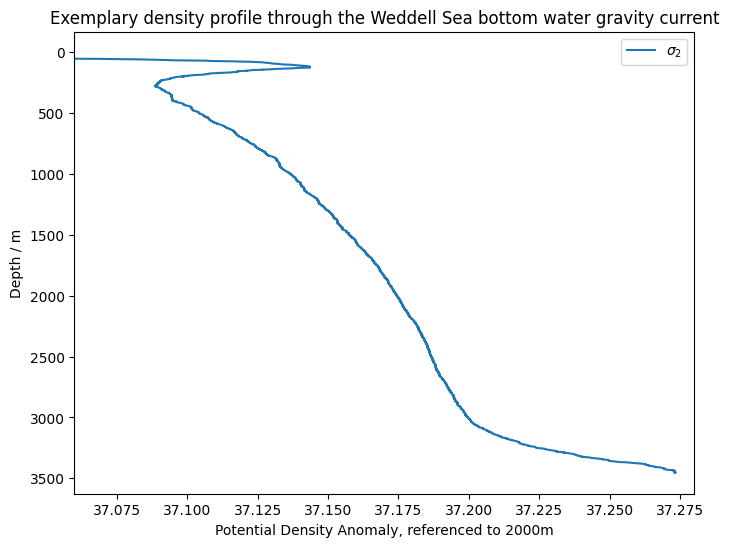

In [25]:
f, ax = plt.subplots()
for i in [2]:
    ax.plot(profile[f"Sigma{i}"], profile["Depth water [m]"], label = f"$\sigma_{i}$")
ax.legend()
ax.invert_yaxis()
ax.set_xlim(37.06,37.28)
ax.set_xlabel("Potential Density Anomaly, referenced to 2000m")
ax.set_ylabel("Depth / m")
ax.set_title("Exemplary density profile through the Weddell Sea bottom water gravity current")
ax.set_xlim(37.06,37.28)

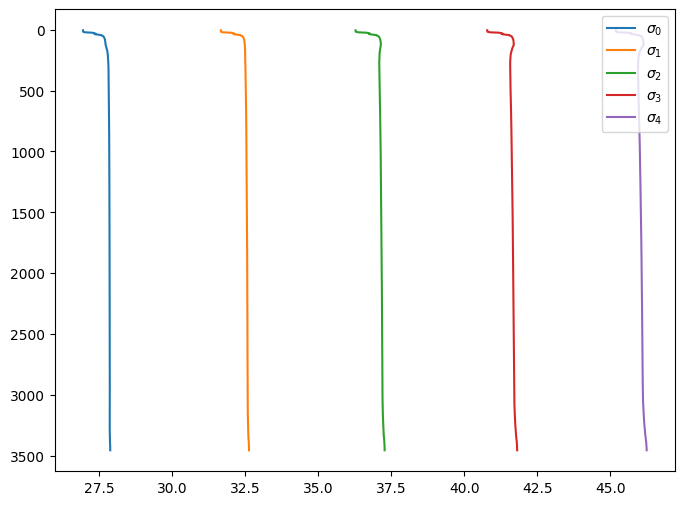

In [26]:
f, ax = plt.subplots()
for i in range(5):
    ax.plot(profile[f"Sigma{i}"], profile["Depth water [m]"], label = f"$\sigma_{i}$")
ax.legend()
ax.invert_yaxis()

We see, choosing the reference pressure definitely changes the mean density of each new profile.

But if we lay all the potential density anomaly profiles on top of each other, we see also differences in the profile shape.

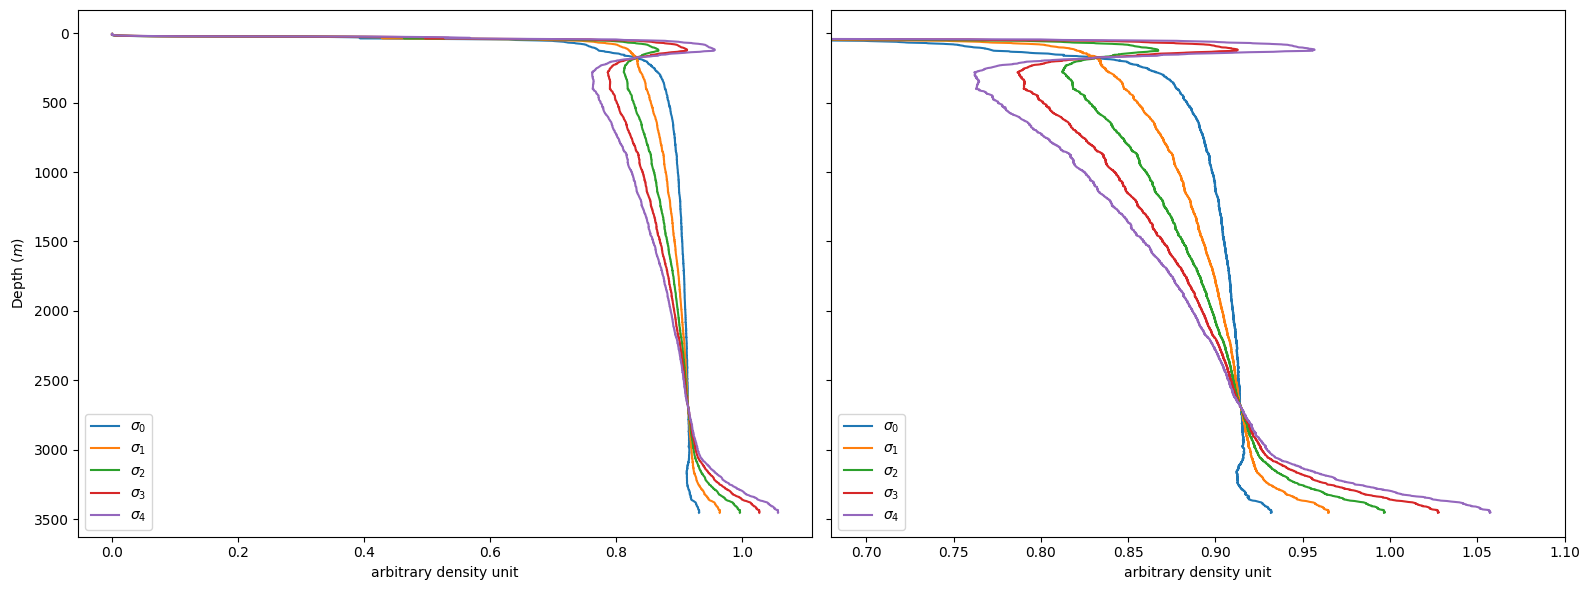

In [27]:
f, axis = plt.subplots(ncols = 2, sharey = True, figsize=(16, 6))
for ax in axis:
    for i in range(5):
        ax.plot(
            profile[f"Sigma{i}"]-profile[f"Sigma{i}"].iloc[0],
            profile["Depth water [m]"],
            label = f"$\sigma_{i}$",
            )
    ax.legend(loc = "lower left")
axis[1].set_xlim(0.68,1.1)
axis[0].invert_yaxis()
for ax in axis:
    ax.set_xlabel("arbitrary density unit")
axis[0].set_ylabel("Depth ($m$)")
f.tight_layout()

DESCRIPTION ???????????????????????????????????????

# Buoyancy frequency

## Why $N^2$ ??????????????

Although the Gibbs Seawater Toolbox calculates $N^2$ from absolute salinity **SA** and conservative temperature **CT** ([see GSW documentation]), it is usually ([see Wikipedia:Brunt–Väisälä frequency]) defined as
## $ N^2(z) = \frac{g}{\rho_{\mathrm{pot}}(z)} \frac{d\rho_{\mathrm{pot}}(z)}{dz} $

Because we defined the water depth z as positive, we have to leave out the minus sign from the referenced formula. We can check our result, as $N^2$ should be mostly positive, meaning a stable water column.
    
[see GSW documentation]: https://teos-10.github.io/GSW-Python/stability.html
[see Wikipedia:Brunt–Väisälä frequency]: https://en.wikipedia.org/wiki/Brunt%E2%80%93V%C3%A4is%C3%A4l%C3%A4_frequency

<font size = 6, color='red'> !! Note about units !!</font>

The gsw function *Nsquared* returns $N^2$ in units of *(rad/s)$^2$*. This is in some publications and textbook misleadingly abbreviated as *(1/s)$^2$*, but should <font color='red'> not </font> be confused with *(Hz)$^2$*. For that you need to divide by $(2\pi)^2$ .

I am currently still trying to understand why the definition in terms of the potential density also yields an result in units of *(rad/s)$^2$* and will update this text accordingly.

In [28]:
def Nsquared(rho, z):
    g = 9.8
    return g/rho * np.gradient(rho, z)

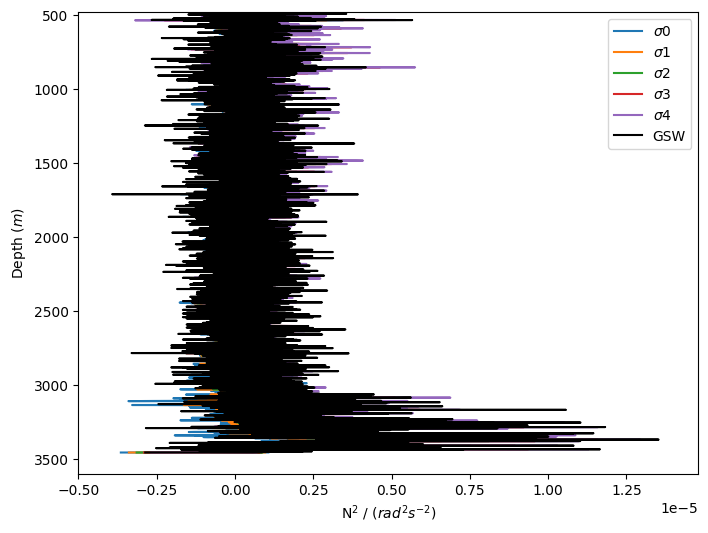

In [29]:
f,ax = plt.subplots()

#Plot N^2 from potential densities
for i in range(5):
    rho_pot =  profile[f"Sigma{i}"] + 1000
    z = profile["Depth water [m]"]
    N2 = Nsquared(rho_pot, z)
    ax.plot(N2,z, label = f"$\sigma{i}$")

#Plot GSW result
N2_in_rad_sqrd, N2pressure = gsw.Nsquared(
    SA = profile["Absolute Salinity"],
    CT = profile["Conservative Temperature"],
    p = profile["Press [dbar]"],
    lat = profile["Latitude"]
)
N2 = N2_in_rad_sqrd #/ (2*np.pi)**2
N2depth = -1*gsw.z_from_p(p = N2pressure, lat = profile["Latitude"].mean())
ax.plot(N2,N2depth, label = "GSW", color = "k")

#improve figure
ax.legend()
ax.set_ylim(480,3600)
ax.set_ylabel("Depth ($m$)")
ax.set_xlim(-5e-6,1.48e-5)
ax.set_xlabel("N$^2$ / ($rad^2 s^{-2}$)")
ax.invert_yaxis()

The difference between the lines is impossible to see, therefore we smooth out the profiles by convolving the data with a Hanning window.

In [30]:
def smooth(array,length = 32):
    """
    smooth an array by convolving it with a window of default width 32 points
    """
    window = signal.windows.hann(length)  # construct Hanning window
    smoothed = signal.convolve(array, window, mode="same") / np.sum(window) #convolve and normalize with window weight
    return smoothed

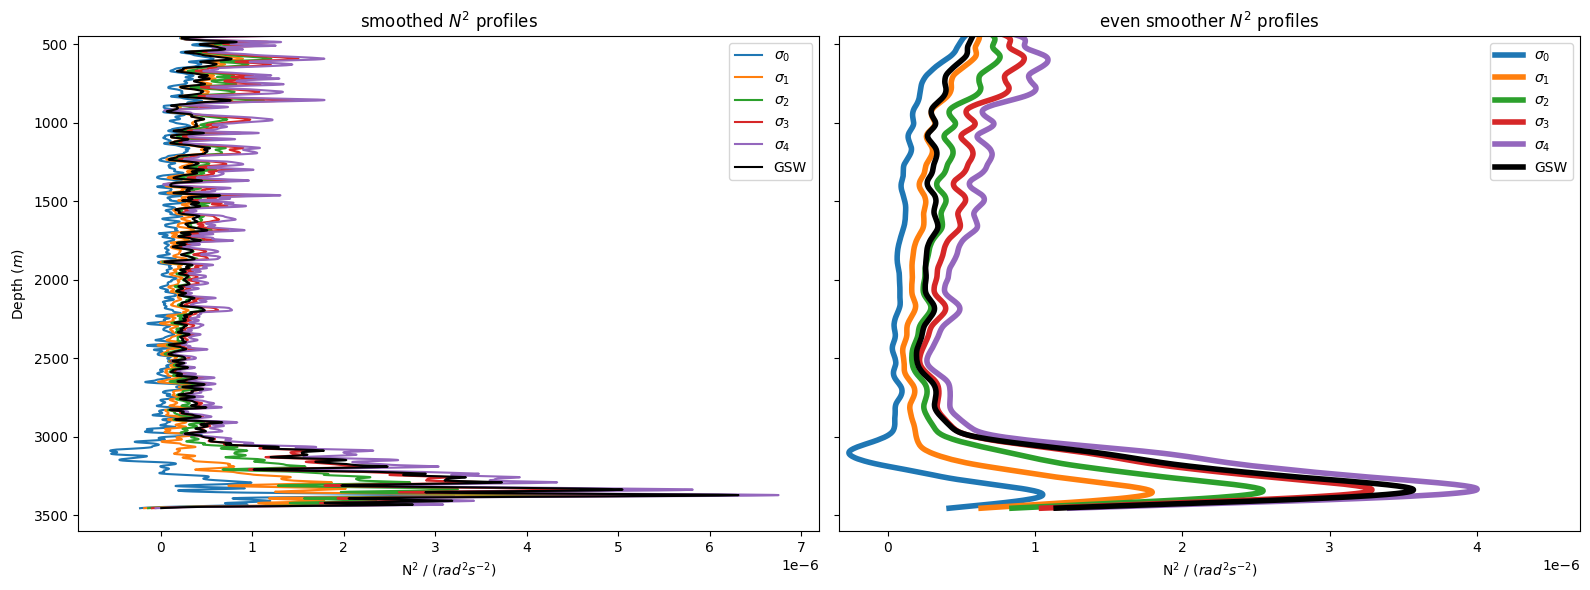

In [31]:
f,axis = plt.subplots(ncols = 2, sharey = True, figsize=(16, 6))

#Plot N^2 from potential densities
for i in range(5):
    rho_pot =  profile[f"Sigma{i}"] + 1000
    z = profile["Depth water [m]"]
    N2 = Nsquared(rho_pot, z)
    axis[0].plot(smooth(N2),z, label = f"$\sigma_{i}$")
    axis[1].plot(smooth(N2,256),z, label = f"$\sigma_{i}$", lw = 4)

#Plot GSW result
N2_in_rad_sqrd, N2pressure = gsw.Nsquared(
    SA = profile["Absolute Salinity"],
    CT = profile["Conservative Temperature"],
    p = profile["Press [dbar]"],
    lat = profile["Latitude"]
)
N2 = N2_in_rad_sqrd #/ (2*np.pi)**2
N2depth = -1*gsw.z_from_p(p = N2pressure, lat = profile["Latitude"].mean())
axis[0].plot(smooth(N2),N2depth, label = "GSW", color = "k")
axis[1].plot(smooth(N2,256),N2depth, label = "GSW", color = "k", lw = 4)

#improve figure
for ax in axis:
    ax.legend()
    ax.set_ylim(450,3600)
    ax.set_xlabel("N$^2$ / ($rad^2 s^{-2}$)")
axis[0].set_ylabel("Depth ($m$)")
axis[0].invert_yaxis()
axis[0].set_xlim(-9e-7,7.2e-6)
axis[1].set_xlim(-3.3e-7,4.7e-6)
axis[0].set_title("smoothed $N^2$ profiles")
axis[1].set_title("even smoother $N^2$ profiles")
f.tight_layout()

We can see in the left subfigure that the colored lines overlap with the black line only at the respective reference pressures ot the potential densities.  

# Conclusion

The choice of the reference pressure heavily influences the resulting potential density profile. If you happened to use a reference too far from the depth of interest to you, the local stratification can be completely meaningless, for example by implying an instable section water column. So be mindful of what you do and select the right conversion function for your oceanographic endeavours.